In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook
import warnings;
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Function definitions
def readESC(sounding_path, interpnan=True, handle=False):
    """
    Reads in a sounding in ESC format from a provided file path or handle (can be a StringIO object or an open
    file handle)
    """
    col_names = ['pressure','temperature','dewpoint','u_wind','v_wind','speed','direction','height',
                 'Qp_code','Qt_code','Qrh_code','Qu_code','Qv_code']
    # First read the file and extract the field widths from the 14th header line
    if not handle:
        f = open(sounding_path, 'r')
    else:
        f = sounding_path

    # Read in the header and extract some metadata from it
    dummy = f.readline()
    dummy = f.readline()
    header2 = f.readline().strip().split(':')
    # Read next header line and extract station id and wmo number from it (if it exists)
    staid_wmo_str = header2[1]
    if ' / ' in staid_wmo_str:
        staid_wmo = staid_wmo_str.strip().split(' / ')
        staid = staid_wmo[0][1:4]
        wmo = int(staid_wmo[1])
    else:
        if '. ' in staid_wmo_str:
            staid = staid_wmo_str.replace('. ', '').strip()[:4]
        else:
            staid = staid_wmo_str.strip()[:4]
            staid = staid.replace(" ", "")
        wmo = 99999
    print(staid)
    # Read the next header line and extract the location information from it
    header3 = f.readline().strip().split(':')
    location = header3[1].strip().split(',')
    print(location)
    lon = np.float(location[2])
    lat = np.float(location[3])
    elev = np.float(location[4])
    # Read the next header line and extract the time information from it
    header4 = f.readline().strip()[31:].lstrip()   
    sounding_datetime = datetime.strptime(header4, '%Y, %m, %d, %H:%M:%S')
    
    # Now read and dump the rest of the header
    for i in range(9):
        f.readline()
    
    # Except for the last header line, which is used to determine the widths of the fields
    line = f.readline().strip().split()
    fw = [len(field)+1 for field in line]

    # Now read the file into the dataframe, using the extracted field widths
    df = pd.read_fwf(f, usecols=[1, 2, 3, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19],
                     names=col_names, na_values=['99999.0', '9999.0', '999.0'], widths=fw)
    
    # For some reason, need to convert all the columns to floating point here, as some get interpreted as strings
    # when they shouldn't be...
    # print(df['pressure'], df['temperature'])
    for column in df.columns:
        df[column] = df[column].astype(np.float)
    
    # Drop rows where height or pressure is NaN. TODO: Can't remember why I have to use reset_index(drop=True). 
    # Figure this out.
    df = df.dropna(subset=('height', 'pressure')).reset_index(drop=True)
    # Set the height as the index so we can use it as weights to interpolate other columns across NaN
    df = df.set_index('height')
    df['height'] = df.index
    
    if interpnan:
        # First convert direction and speed to u, v components
        df['u'], df['v'] = mpcalc.wind_components(df['speed'].values*units('m/s'),
                                                      df['direction'].values*units.degrees)
        # Now interpolate
        df = df.interpolate(method='values')
        # Finally recompute direction and speed from u, v components
        df['speed'] = mpcalc.wind_speed(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
        df['direction'] = mpcalc.wind_direction(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
    else:
        # Drop any rows with all NaN values for T, Td, winds
        df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                               'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    
    df = df[(df.Qp_code == 1.0) & (df.Qt_code == 1.0) & (df.Qrh_code == 1.0) & (df.Qu_code == 1.0) & 
            (df.Qv_code == 1.0)]

    nlines = df.count()['pressure']
    
    if not handle:
        f.close()
    
    snd_metadata = {
        'sounding_datetime': sounding_datetime,
        'lat': lat,
        'lon': lon,
        'selev': elev,
        'staid': staid,
        'wmo': wmo,
        'nlevs': nlines,
        'staid_long': staid_wmo_str
    }
    
    return snd_metadata, df


def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)


def rain_Brandes(D):
    """Given a range of diameters D, compute rain fall speed curve, a quartic polynomial
       fit after Brandes et al. (2002)."""
    
    D_mm=D*1000. # get it to (mm)
    
    Vtr = -0.1021 + 4.932*D_mm - 0.9551*D_mm**2. + 0.07934*D_mm**3. - 0.002362*D_mm**4.
    
    return Vtr


def cal_xf_tf(usm, vsm, vt, H, perturb_vt=False, sigma=0.1):
    """Computes final horizontal position and residence time (relative to starting position) of a raindrop
       falling through a horizontally homogeneous layer H with terminal velocity vt and 
       storm releative mean wind given by (usm, vsm)."""
    
    if perturb_vt:
        rng = np.random.default_rng()
        vt_perts = sigma * rng.standard_normal(vt.size)
        vt = vt + vt_perts
    
    tf = H / vt
    xf = tf * usm
    yf = tf * vsm
    
    return xf, yf, tf


def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def interpolate_all(gridded_radar, tinterp_intv, base_field_name='reflectivity_masked'):
    # Get list of intervals in seconds between subsequent radar times
    tdiffs = gridded_radar['time_seconds'].diff(dim='time')
    
    # This list will hold all the time-interpolated grids (xarray Datasets). 
    # Can later be concatenated into a new xarray Dataset containing all times
    gridded_radar_interp_list = []
    
    # Grab first time from full dataset and restore singular time dimension
    first_time_ds = gridded_radar.isel(time=0)
    first_time_ds = first_time_ds.expand_dims(dim='time')

    gridded_radar_interp_list.append(first_time_ds)
    
#     tbgn = first_time_ds.coords['time_seconds'].values.item()  # Need to get scalar value, not 0-d
#                                                                # numpy array
    
    # Loop through the gridded_radar times, perform advection correction/interpolation between successive times
    # and add each to the list, making sure the time coordinate is consistent
    # new_time = tbgn
    for i, tdiff in enumerate(tdiffs.values):
        gridded_radar_interp_sublist = advection_correction_ds(gridded_radar.isel(time=slice(i, i+2)), 
                                                               tdiff, tinterp_intv, 
                                                               base_field_name=base_field_name)
        for t, gridded_radar_interp in enumerate(gridded_radar_interp_sublist):
#             new_time = new_time + tinterp_intv
#             new_ds = first_time_ds.copy()
#             new_ds[:] = gridded_radar_interp
#             new_ds.coords['time'] = new_ds['time'] + np.timedelta64(int(new_time), 's')
#             new_ds.coords['time_seconds'] = new_time
            gridded_radar_interp_list.append(gridded_radar_interp)
    
    return gridded_radar_interp_list


def advection_correction_ds(radar_ds, tintv_obs, tintv, base_field_name='reflectivity_masked', method="LK"):
    # Evaluate advection
    oflow_method = motion.get_method(method)
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects

    base_field = radar_ds[base_field_name]
    oflow_field = oflow_method(base_field, fd_kwargs=fd_kwargs)
    
    # Perform temporal interpolation on all variables in Dataset using the flow field derived from the "base"
    # field (by default, reflectivity)
    
    tbgn = base_field[0].coords['time_seconds'].values.item()   # Need to get scalar value, not 0-d
                                                                # numpy array
    print(tbgn)
    print(tintv)
    radar_ds_list = []
    x, y = np.meshgrid(
        np.arange(base_field[0].shape[1], dtype=float), np.arange(base_field[0].shape[0], dtype=float),
    )
    
    new_time = tbgn
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        new_time = new_time + tintv
        
        pos1 = (y - i / tintv_obs * oflow_field[1], x - i / tintv_obs * oflow_field[0])
        pos2 = (y + (tintv_obs - i) / tintv_obs * oflow_field[1], 
                x + (tintv_obs - i) / tintv_obs * oflow_field[0])
        
        field_interp_list = []
        for field_name, field_da in radar_ds.items():
            fieldt1 = map_coordinates(field_da[0], pos1, order=1)
            fieldt2 = map_coordinates(field_da[1], pos2, order=1)
       
            field_interp = field_da.isel(time=[0]).copy()
            field_interp[:] = ((tintv_obs - i) * fieldt1 + i * fieldt2) / tintv_obs
            try:
                field_interp.coords['time'] = field_interp['time'] + np.timedelta64(int(new_time - tbgn), 's')
            except TypeError:
                field_interp.coords['time'] = field_interp['time'] + timedelta(seconds=int(new_time - tbgn))
            field_interp.coords['time_seconds'] = new_time
            field_interp_list.append(field_interp)
        
        radar_ds_interp = xr.merge(field_interp_list)
        radar_ds_list.append(radar_ds_interp)
        
    return radar_ds_list


def advection_correction(arr, tintv_obs, tintv):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (5 min)
    t = interpolation timestep (1 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(arr, fd_kwargs=fd_kwargs)

    # Perform temporal interpolation
    # arr_d = np.zeros((arr[0].shape))
    arr_list = []
    x, y = np.meshgrid(
        np.arange(arr[0].shape[1], dtype=float), np.arange(arr[0].shape[0], dtype=float),
    )
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        pos1 = (y - i / tintv_obs * V[1], x - i / tintv_obs * V[0])
        R1 = map_coordinates(arr[0], pos1, order=1)
        
        pos2 = (y + (tintv_obs - i) / tintv_obs * V[1], x + (tintv_obs - i) / tintv_obs * V[0])
        R2 = map_coordinates(arr[1], pos2, order=1)

        arr_interp = ((tintv_obs - i) * R1 + i * R2) / tintv_obs
        arr_list.append(arr_interp)

    return arr_list

In [3]:
# Read in the gridded radar data
radar_name = 'KHTX'
radar_type= 'NEXRAD'

# For 04/30 case
date = '0430'
radar_start_datetimestamp = '20170430190000'
radar_end_datetimestamp = '20170430235959'

# For 03/27 case
# date = '0327'
# radar_start_datetimestamp = '20170327190000'
# radar_end_datetimestamp = '20170327220000'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW'
radar_basedir = os.path.join(radar_basedir, '{}/{}'.format(date, radar_name[1:]))
gridded_radar_dir = os.path.join(radar_basedir, 'gridded_new')

radar_start_timestamp = datetime_start.strftime('%H%M%S')
radar_end_timestamp = datetime_end.strftime('%H%M%S')
gridded_radar_combined_filename = '{}_{}_{}_gridded.nc'.format(radar_name, radar_start_timestamp,
                                                               radar_end_timestamp)

gridded_radar_combined_filepath = os.path.join(gridded_radar_dir, gridded_radar_combined_filename)
if os.path.exists(gridded_radar_combined_filepath):
    # Read in file since we already dumped it out in a previous run of the notebook
    gridded_radar_xr = xr.open_dataset(gridded_radar_combined_filepath)
else:
    # Read in individual gridded radar volumes, stack them into a combined Dataset and dump to disk
    gridded_radar_paths = glob.glob(gridded_radar_dir + '/{}2017{}_*V06_gridded.nc'.format(radar_name, date))
    gridded_radar_paths = sorted(gridded_radar_paths)
    gridded_radar_input_list = []
    for path in gridded_radar_paths:
        filename = os.path.basename(path)
        file_timestamp = filename[4:19]
        file_datetime = datetime.strptime(file_timestamp, '%Y%m%d_%H%M%S')
        if file_datetime >= datetime_start and file_datetime <= datetime_end:
            gridded_radar_input_list.append(path)
    gridded_radar_list = []
    gridded_radar_xr_list = []
    for gridded_radar_path in gridded_radar_input_list:
        print("Reading {}".format(os.path.basename(gridded_radar_path)))
        gridded_radar = pyart.io.read_grid(gridded_radar_path)
        gridded_radar_xr = gridded_radar.to_xarray()
        gridded_radar_xr_list.append(gridded_radar_xr)
    gridded_radar_xr = xr.concat(gridded_radar_xr_list, dim='time')
    print("Writing {}".format(gridded_radar_combined_filename))
    gridded_radar_xr.to_netcdf(gridded_radar_combined_filepath)

print(gridded_radar_xr)

<xarray.Dataset>
Dimensions:                    (time: 47, x: 247, y: 247, z: 41)
Coordinates:
  * time                       (time) datetime64[ns] 2017-04-30T19:01:30.5260...
  * z                          (z) float64 500.0 600.0 700.0 ... 4.4e+03 4.5e+03
    lat                        (y) float64 ...
    lon                        (x) float64 ...
  * y                          (y) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
  * x                          (x) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
Data variables:
    differential_reflectivity  (time, z, y, x) float32 ...
    reflectivity               (time, z, y, x) float32 ...
    cross_correlation_ratio    (time, z, y, x) float32 ...
    ROI                        (time, z, y, x) float32 ...


In [4]:
plot_dir = '/Users/dawson29/Dropbox/Presentations/AMS2021/plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [8]:
# Check to see if masked versions of reflectivity and differential reflectivity exist in the file. 
# If not, create them here.
ZH_thresh = 5.
ZDR_thresh = 0.1

print("Z and ZDR thresholds are {:f} and {:f}".format(ZH_thresh, ZDR_thresh))

if 'reflectivity_masked' not in gridded_radar_xr:
    print("Masking Z and ZDR on thresholds of {:f} and {:f}".format(ZH_thresh, ZDR_thresh))
    ZH_mask = np.where(gridded_radar_xr['reflectivity'] < ZH_thresh, True, False)
    ZH_mask = np.where(np.isfinite(gridded_radar_xr['reflectivity']), ZH_mask, False)
    ZDR_mask = np.where(gridded_radar_xr['differential_reflectivity'] < ZDR_thresh, True, False)
    ZDR_mask = np.where(np.isfinite(gridded_radar_xr['differential_reflectivity']), ZDR_mask, False)
    full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)

    gridded_radar_xr['reflectivity_masked'] = gridded_radar_xr['reflectivity'].where(~full_mask)
    gridded_radar_xr['differential_reflectivity_masked'] = \
        gridded_radar_xr['differential_reflectivity'].where(~full_mask)
    print("Writing {}".format(gridded_radar_combined_filename))
    gridded_radar_xr.to_netcdf(gridded_radar_combined_filepath)
print(gridded_radar_xr)

Z and ZDR thresholds are 5.000000 and 0.100000
Masking Z and ZDR on thresholds of 5.000000 and 0.100000
Writing KHTX_190000_235959_gridded.nc


PermissionError: [Errno 13] Permission denied: b'/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW/0430/HTX/gridded_new/KHTX_190000_235959_gridded.nc'

In [ ]:
# Read in PIPS data
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'
PIPS_filename = 'parsivel_combined_FMCW_2017_{}17_PIPS2A_60s.nc'.format(date)
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.load_dataset(PIPS_filepath)
print(PIPS_ds)

In [ ]:
# Grab the location of the PIPS
PIPS_loc = eval(PIPS_ds.location)
PIPS_lat = PIPS_loc[0]
PIPS_lon = PIPS_loc[1]
print(PIPS_loc)
print(PIPS_lat, PIPS_lon)

In [ ]:
# Read in sounding file to get low-level wind field and then derive storm-relative wind
# Storm motion taken from subjective reflectivity tag tracking using GRLevel2
ustorm = 12.51
vstorm = 12.95

# EDIT: setting ustorm, vstorm to 0 to force ground-relative flow
ustorm = 0.
vstorm = 0.

sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/soundings/COMP5mb'
sounding_filename = 'Hollywood_201704301954.cls'
sounding_path = os.path.join(sounding_dir, sounding_filename)
sounding_metadata, sounding_df = readESC(sounding_path)

In [9]:
datetime_substart = datetime_start
datetime_subend = datetime_end
timestamp_substart = datetime_substart.strftime('%Y-%m-%dT%H:%M')
timestamp_subend = datetime_subend.strftime('%Y-%m-%dT%H:%M')

gridded_radar_xr_subset = gridded_radar_xr.sel(time=slice(timestamp_substart, timestamp_subend))
print(gridded_radar_xr_subset['time'])

# Round times to nearest minute
rounded_times = gridded_radar_xr_subset['time'].dt.round('60S')
print(rounded_times)
gridded_radar_xr_subset['time'] = rounded_times

time_seconds = (gridded_radar_xr_subset['time'] - gridded_radar_xr_subset['time'][0]) / np.timedelta64(1, 's')
print(time_seconds)
gridded_radar_xr_subset.coords['time_seconds'] = ('time', time_seconds)
print(gridded_radar_xr_subset)
# total_seconds = (gridded_radar_xr_subset['time'] - gridded_radar_xr_subset['time'][0]).total_seconds()

<xarray.DataArray 'time' (time: 47)>
array(['2017-04-30T19:01:30.526000000', '2017-04-30T19:06:36.034000000',
       '2017-04-30T19:12:07.401000000', '2017-04-30T19:17:35.576000000',
       '2017-04-30T19:22:57.009000000', '2017-04-30T19:28:20.583000000',
       '2017-04-30T19:34:14.451000000', '2017-04-30T19:40:13.330000000',
       '2017-04-30T19:46:28.651000000', '2017-04-30T19:52:42.071000000',
       '2017-04-30T19:58:45.664000000', '2017-04-30T20:05:32.284000000',
       '2017-04-30T20:12:18.579000000', '2017-04-30T20:19:04.085000000',
       '2017-04-30T20:25:50.555000000', '2017-04-30T20:32:37.051000000',
       '2017-04-30T20:39:13.380000000', '2017-04-30T20:45:50.207000000',
       '2017-04-30T20:52:09.289000000', '2017-04-30T20:58:23.994000000',
       '2017-04-30T21:05:00.147000000', '2017-04-30T21:11:36.716000000',
       '2017-04-30T21:18:04.199000000', '2017-04-30T21:24:23.401000000',
       '2017-04-30T21:30:42.971000000', '2017-04-30T21:37:02.543000000',
       '2017-0

In [10]:
# Extract one level from the gridded radar Dataset
height = 1000.
gridded_radar_xr_subset_onelevel = gridded_radar_xr_subset.sel(z=height).squeeze()
gridded_radar_xr_subset_onelevel = gridded_radar_xr_subset_onelevel.transpose("time", "y", "x")

(2, 247, 247)
4.121136597951332 6.968096312979091


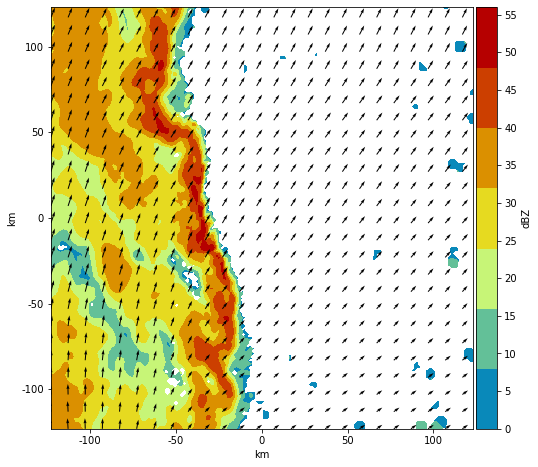

In [12]:
# Use pysteps for advection correction and temporal interpolation
from pysteps import io, motion, rcparams
from scipy.ndimage import map_coordinates

oflow_method = motion.get_method("LK")
fd_kwargs = {"buffer_mask": 10} # avoid edge effects

# Plot example of optical flow field
dBZ = gridded_radar_xr_subset_onelevel['reflectivity_masked']
# print(dBZ[0])
velocity_field = oflow_method(dBZ[11:13], fd_kwargs=fd_kwargs)

qintv = 10
xplt = gridded_radar_xr_subset_onelevel['x']
yplt = gridded_radar_xr_subset_onelevel['y']
uplt = velocity_field[0]
vplt = velocity_field[1]
print(velocity_field.shape)
fig, ax = plt.subplots(figsize=(8, 8))
clevels = np.arange(0., 61., 1.)
dBZ = ax.contourf(xplt, yplt, dBZ[11], clevels=clevels, cmap='pyart_HomeyerRainbow')
ax.quiver(xplt[::qintv], yplt[::qintv], uplt[::qintv,::qintv], vplt[::qintv,::qintv])
cbarintv = 5.
cbarlevels = ticker.MultipleLocator(base=cbarintv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(dBZ, orientation='vertical', ticks=cbarlevels, cax=cax)
cax.set_ylabel('dBZ')
formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_aspect('equal')

plot_filename='pysteps_adv_correction_example.png'
plot_filepath = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

print(uplt.mean(), vplt.mean())

In [ ]:
# Perform advection correction and interpolate gridded radar sequence to 1-min intervals
# Just do Z and ZDR

gridded_Z_ZDR = gridded_radar_xr_subset_onelevel[['reflectivity_masked', 'differential_reflectivity_masked']]
tinterp_intv = 60.

print(gridded_Z_ZDR)

# print(gridded_Z_ZDR.isel(time=[0]))

# for varname, var in gridded_Z_ZDR.items():
#     print(varname)
#     print(var[1])

gridded_Z_ZDR_interp_list = interpolate_all(gridded_Z_ZDR, tinterp_intv, 
                                            base_field_name='reflectivity_masked')


In [ ]:
gridded_Z_ZDR_interp_ds = xr.concat(gridded_Z_ZDR_interp_list, 'time')
print(gridded_Z_ZDR_interp_ds)

In [ ]:
# Apply retrieval to get N0, alpha, and lamda
# at 1-min intervals. Then compute N(D)
# Then get times that different D reach surface. Store as new coordinate
# Do "groupby_bins" operation on new coordinate to bin up trajectories within 1-min bins
# Then either do the numpy histogram 2d thing or find another way 


In [ ]:
# Set retrieval lookup table to use
retrieval_tag = 'Z01'
lookup_dir = os.path.join('/Users/dawson29/Projects/pyPIPS/data/lookups/', retrieval_tag)

# Retrieve gamma DSD parameters from ZH and ZDR
print("Getting ZH and ZDR fields")
# Get the ZH and ZDR fields from the xarray Dataset
ZH_rad = gridded_Z_ZDR_interp_ds['reflectivity_masked']
ZDR_rad = gridded_Z_ZDR_interp_ds['differential_reflectivity_masked']

# Read in first lookup table to get the interval between reflectivity and ZDR
lookup_path = os.path.join(lookup_dir, 'D0.csv')
retr_table = pd.read_csv(lookup_path, sep=',', header=0, index_col='dBZ')
# Massage the index and column labels to get rid of extraneous zeros
# Also convert column labels from strings to floats
retr_table.index = retr_table.index.to_series().apply(np.around, decimals=4)
retr_table.columns = [np.around(np.float(col), decimals=4) for col in retr_table.columns]

dBZ_lookup_min = retr_table.index[0]
dBZ_lookup_max = retr_table.index[-1]
ZDR_lookup_min = retr_table.columns[0]
ZDR_lookup_max = retr_table.columns[-1]
dBZ_intv = retr_table.index[1] - retr_table.index[0]
ZDR_intv = float(retr_table.columns[1]) - float(retr_table.columns[0])

# Replace masked entries in ZH_rad and ZDR_rad with the minimum value of the lookup table
ZH_mask = ZH_rad.isnull()
ZDR_mask = ZDR_rad.isnull()
full_mask = xr.where(ZH_mask | ZDR_mask, True, False)
ZH_rad = ZH_rad.fillna(dBZ_lookup_min)
ZDR_rad = ZDR_rad.fillna(ZDR_lookup_min)
# Now limit values to within lookup table limits
ZH_rad = ZH_rad.where(ZH_rad > dBZ_lookup_min, dBZ_lookup_min)
ZH_rad = ZH_rad.where(ZH_rad < dBZ_lookup_max, dBZ_lookup_max)
ZDR_rad = ZDR_rad.where(ZDR_rad > ZDR_lookup_min, ZDR_lookup_min)
ZDR_rad = ZDR_rad.where(ZDR_rad < ZDR_lookup_max, ZDR_lookup_max)
# Round ZH and ZDR fields to the nearest interval
ZH_round = roundPartial(ZH_rad, dBZ_intv)
ZDR_round = roundPartial(ZDR_rad, ZDR_intv)
# Get the shape of the arrays for later, so we can reshape the flattened arrays of retrieved
# values
ZH_shape = ZH_round.shape
print(ZH_shape)
ZH_flat = ZH_round.values.flatten()
ZDR_flat = ZDR_round.values.flatten()
print(ZH_flat.max())
print(ZDR_flat.max())

In [ ]:
retr_var_da_dict = {}
for retr_varname in radar.retrieval_metadata.keys():
    print("Retrieving {} using lookup tables".format(retr_varname))
    lookup_path = os.path.join(lookup_dir, '{}.csv'.format(retr_varname))
    retr_table = pd.read_csv(lookup_path, sep=',', header=0, index_col='dBZ')
    # Round the indices and columns of the DataFrame (i.e. the dBZ values) to some sane
    # number of decimal places to facilitate using it as a lookup table. The floating point
    # precision gets in the way sometimes here. For example 56.4 is dumped out as
    # 56.4<some bunch of zeros>1
    retr_table.index = retr_table.index.to_series().apply(np.around, decimals=4)
    retr_table.columns = [np.around(np.float(col), decimals=4) for col in
                          retr_table.columns]
    # Gah, for some reason DataFrame.lookup sometimes barfs on perfectly good floating point
    # values in columns, so convert them back to strings here. :rolleyes:
    # EDIT 11/09/2020: Now this is happening for the rows as well. Not sure why... So change the row labels
    # to strings as well.
    retr_table.index = [str(row) for row in retr_table.index]
    retr_table.columns = [str(col) for col in retr_table.columns]
    # print(list(retr_table.index))
    # print(list(retr_table.columns))
    # Ok, now retrieve the desired retrieval variable
    # for each ZH/ZDR pair in the flattened radar sweep
#     for ZH, ZDR in zip(ZH_flat, ZDR_flat):
#         print(ZH, ZDR)
#         retr_val = retr_table.lookup([ZH.astype('str')], [ZDR.astype('str')])
    retr_vals = retr_table.lookup(ZH_flat.astype('str'), ZDR_flat.astype('str'))
    # retr_vals = retr_table.lookup(ZH_flat, ZDR_flat)
    # Reshape back to original shape
    retr_vals_data = retr_vals.reshape(ZH_shape)
    retr_vals_data = np.where(full_mask, np.nan, retr_vals_data)
    # retr_vals_data = np.ma.masked_array(retr_vals_data, mask=full_mask)
    retr_var_da = ZH_rad.copy()
    retr_var_da.name = retr_varname
    retr_var_da[:] = retr_vals_data
    retr_var_da_dict[retr_varname] = retr_var_da

In [ ]:
# Combine retrieved fields and Z and ZDR fields into a single Dataset
gridded_radar_interp_ds = gridded_Z_ZDR_interp_ds.copy()
for varname, var_da in retr_var_da_dict.items():
    gridded_radar_interp_ds[varname] = var_da
    
print(gridded_radar_interp_ds)

In [ ]:
# Save interpolated grid to file
out_start_timestamp = datetime_substart.strftime('%Y%m%d%H%M')
out_end_timestamp = datetime_subend.strftime('%Y%m%d%H%M')
gridded_radar_interp_filename = '{}_{}_{}_z{:d}_gridded_interp.nc'.format(radar_name, out_start_timestamp,
                                                                          out_end_timestamp, int(height))
gridded_radar_interp_filepath = os.path.join(gridded_radar_dir, gridded_radar_interp_filename)
gridded_radar_interp_ds.to_netcdf(gridded_radar_interp_filepath)

In [ ]:
# Find PIPS x, y location by interpolating to its lat/lon point
gridded_radar_interp_latlon_ds = gridded_radar_interp_ds.swap_dims({'x': 'lon', 'y': 'lat'})
radar_at_PIPS_da = gridded_radar_interp_latlon_ds.interp(lat=PIPS_lat, lon=PIPS_lon)
PIPS_x = radar_at_PIPS_da['x'].values.item()
PIPS_y = radar_at_PIPS_da['y'].values.item()
print(radar_at_PIPS_da)


In [ ]:
radar_at_PIPS_da['reflectivity_masked'].plot()

In [ ]:
# Plot reflectivity for time-interpolated grid
# Choose a subset of times to keep animation size down
anim_start = '2017-04-30T19:30'
anim_end = '2017-04-30T21:00'

var_da = gridded_radar_interp_ds['reflectivity_masked'].sel(time=slice(anim_start, anim_end))

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    # Plot PIPS location
    ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
print(retr_var_da_dict.keys())

D0_da = retr_var_da_dict['D0']

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(D0_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
# plt.show()

In [ ]:
from IPython.display import HTML

var_da = retr_var_da_dict['mu']

clevels =np.arange(0., 30., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=30.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
# plt.show()

In [ ]:
# Extract within a small bounding box for testing
lat_bgn = 34.3
lat_end = 35.0
lon_bgn = -86.5
lon_end = -85.75

# ibgn = 50
# iend = 150
# jbgn = 125
# jend = 225
# level = 2
# z_level = gridded_radar.point_z['data'][level, 0, 0]
# z_level = 1000.
gridded_radar_interp_ds = gridded_radar_interp_ds.swap_dims({'y': 'lat', 'x': 'lon'})
gridded_radar_subgrid = gridded_radar_interp_ds.sel(lat=slice(lat_bgn, lat_end), lon=slice(lon_bgn, lon_end))
# gridded_radar_subgrid = gridded_radar_subgrid.squeeze()
gridded_radar_subgrid = gridded_radar_subgrid.transpose('time', 'lat', 'lon')
print(gridded_radar_subgrid)

In [ ]:
# Calculate ND for each grid point from gamma dist. parameters using Parsivel bins
avg_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
#avg_diameters = avg_diameters[:, np.newaxis, np.newaxis]
#avg_diameters = xr.DataArray(avg_diameters, dims=['diameter_bin', 'y', 'x'])
avg_diameters = xr.DataArray(avg_diameters, coords = {'diameter': ('diameter_bin', avg_diameters)}, 
                             dims=['diameter_bin'])

lamda = gridded_radar_subgrid['lamda'] * 1000. # get to m^-1
alpha = gridded_radar_subgrid['mu']
N0 = gridded_radar_subgrid['N0'] * 1000**(1 + alpha) # get to m^-4
ND = dsd.calc_binned_DSD_from_params(N0, lamda, alpha, avg_diameters) * 1.e-3 # Get to m^-3 mm^-1
ND.coords['max_diameter'] = ('diameter_bin', pp.parsivel_parameters['max_diameter_bins_mm'])
ND.coords['min_diameter'] = ('diameter_bin', pp.parsivel_parameters['min_diameter_bins_mm'])

In [ ]:
# Set up grid for precip trajectories
height_AGL_snd = sounding_df['height'] - sounding_metadata['selev']
# print(gridded_radar_subgrid['x'])
grid_height = gridded_radar_subgrid['z'].values
# grid_height = 2000.
# print(gridded_radar.origin_altitude)
dz = 1.
new_heights = np.arange(0., grid_height + dz, dz)

# Interpolate sounding u, v to new regularly spaced heights
u_snd = sounding_df['u'].values
f = interpolate.interp1d(height_AGL_snd, u_snd, bounds_error=False, fill_value=(u_snd[0], u_snd[-1]))
ug = f(new_heights)

v_snd = sounding_df['v'].values
f = interpolate.interp1d(height_AGL_snd, v_snd, bounds_error=False, fill_value=(v_snd[0], v_snd[-1]))
vg = f(new_heights)

# Storm-relative winds
usr = ug - ustorm
vsr = vg - vstorm

# Layer-mean storm-relative winds
usm = np.mean(usr)
vsm = np.mean(vsr)
print(usm, vsm)

In [ ]:
# Truncate diameter range to less than 9 mm
D_max = 9.
D_range_full = ND['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_range)
ND_trunc = ND.isel(diameter_bin=slice(0, D_max_ind))

# Compute range of terminal velocities from Brandes relation
vt_range = rain_Brandes(D_range / 1000.)
print(vt_range)

# Set dimensions back from lat/lon to y/x for ND_trunc
ND_trunc = ND_trunc.swap_dims({'lon': 'x', 'lat': 'y'})
ND_trunc = ND_trunc.swap_dims({'time': 'time_seconds'})

# Interpolate ND to a finer grid
# Set up grid of locations
x_coords = ND_trunc['x']
y_coords = ND_trunc['y']
t_coords = ND_trunc['time_seconds']

refinement_factor = 4
time_refinement_factor = 1

new_x_coords = np.linspace(x_coords.x[0], x_coords.x[-1], x_coords.sizes['x'] * refinement_factor)
new_y_coords = np.linspace(y_coords.y[0], y_coords.y[-1], y_coords.sizes['y'] * refinement_factor)
new_t_coords = np.linspace(t_coords.time_seconds[0], t_coords.time_seconds[-1], 
                           t_coords.sizes['time_seconds'] * time_refinement_factor)

ND_trunc = ND_trunc.interp(x=new_x_coords, y=new_y_coords, time_seconds=new_t_coords)

x_grid, y_grid, t_grid = xr.broadcast(ND_trunc['x'], ND_trunc['y'], ND_trunc['time_seconds'])

x_flat = x_grid.stack(loc=['time_seconds', 'y', 'x']).values
y_flat = y_grid.stack(loc=['time_seconds', 'y', 'x']).values
t_flat = t_grid.stack(loc=['time_seconds', 'y', 'x']).values

# Compute horizontal deviations of drops and residence time at bottom of layer for each grid point and drop size
# TODO: Generalize this for spatially varying velocity field. Would require a numerical trajectory integration
# TODO: Update this to perturb the terminal velocities for all grid points (already modified the function above)
xf, yf, tf = cal_xf_tf(usm, vsm, vt_range, grid_height)
x_flat_f = x_flat[:, np.newaxis] + xf
y_flat_f = y_flat[:, np.newaxis] + yf

# Create array of times corresponding to each initial time for trajectory endpoints as a function of diameter
t_flat_f = t_flat[:, np.newaxis] + tf

x_flat_f = x_flat_f.T
y_flat_f = y_flat_f.T
t_flat_f = t_flat_f.T

# Perturb the endpoints a bit in space and time
xpertscale = 20. # m
tpertscale = 1. # s
rng = np.random.default_rng()
xpert = xpertscale * rng.standard_normal(size=x_flat_f.shape)
ypert = xpertscale * rng.standard_normal(size=y_flat_f.shape)
tpert = tpertscale * rng.standard_normal(size=t_flat_f.shape)

xpert = np.where(xpert < -10.*xpertscale, 0., xpert)
xpert = np.where(xpert > 10.*xpertscale, 0., xpert)
ypert = np.where(ypert < -10.*xpertscale, 0., ypert)
ypert = np.where(ypert > 10.*xpertscale, 0., ypert)
tpert = np.where(tpert < -10.*tpertscale, 0., tpert)
tpert = np.where(tpert > 10.*tpertscale, 0., tpert)

x_flat_f = x_flat_f + xpert
y_flat_f = y_flat_f + ypert
t_flat_f = t_flat_f + tpert

ND_trunc = ND_trunc.transpose('diameter_bin', 'time_seconds', 'y', 'x')
print(x_flat_f.shape, y_flat_f.shape, t_flat_f.shape)

In [ ]:
# Set up 3D bins (2 for space, 1 for time) for bottom of sorting layer

dx_bins = 500.
dx_orig = new_x_coords[1] - new_x_coords[0]
print("dx (top), dx (bottom)", dx_orig, dx_bins)
area_ratio = dx_bins**2. / dx_orig**2.
print("area ratio: ", area_ratio)
# Get bounding box of bottom of domain
xmin = int(x_flat_f.min()) # -5000.
xmax = int(x_flat_f.max())
ymin = int(y_flat_f.min()) # -5000.
ymax = int(y_flat_f.max())

# Create bins for bottom of domain
xbins = int((xmax-xmin)/dx_bins)
ybins = int((ymax-ymin)/dx_bins)

print(xbins)
print(ybins)
xmax = xmin+dx_bins*xbins # +5000.
ymax = ymin+dx_bins*ybins # +5000.
print(xmin, xmax, ymin, ymax)

# Set up time bins
# EDIT: just use original time bins
tintv = 60.
# tmin = t_flat_f.min()
# tmax = t_flat_f.max()
# print(tmin, tmax)
# tbins = int((tmax - tmin) / tintv)
tmin = ND_trunc['time_seconds'][0].values
tmax = ND_trunc['time_seconds'][-1].values + tintv
tbins = int((tmax - tmin) / tintv)
print(tmin, tmax, tbins)



In [ ]:
# Create 3D histogram (x, y, t) for number density for each diameter bin for drop trajectory endpoints

ND_D_binned_list = []

for i, ND_D in enumerate(ND_trunc):
    print("Index: ", i)
    x = x_flat_f[i]
    y = y_flat_f[i]
    t = t_flat_f[i]
    
    coords = np.stack([x, y, t], axis=1)
    ND_D_binned, edges = np.histogramdd(coords,
                                        bins=[xbins, ybins, tbins],
                                        range=[[xmin, xmax], [ymin, ymax], [tmin, tmax]],
                                        weights=ND_D.values.flatten())
    ND_D_binned_list.append(ND_D_binned)

    
ND_D_binned = np.array(ND_D_binned_list)
xedges, yedges, tedges = edges
start_time = ND['time'][0].values
attrs = {"units": "seconds since {}".format(start_time)}

ND_f_da = xr.DataArray(ND_D_binned,
                       coords={
                           "diameter": ND_trunc['diameter'], 
                           "x": xedges[:-1],
                           "y": yedges[:-1],
                           "time_seconds": tedges[:-1],
                       },
                       dims=["diameter_bin", "x", "y", "time_seconds"])

ND_f_da.coords["time"] = ("time_seconds", ND_f_da["time_seconds"], attrs)
ND_f_ds = xr.decode_cf(ND_f_da.to_dataset(name='ND'))
ND_f_ds = ND_f_ds.swap_dims({"time_seconds": "time"})
ND_f_ds.coords['max_diameter'] = ('diameter_bin', pp.parsivel_parameters['max_diameter_bins_mm'][:D_max_ind])
ND_f_ds.coords['min_diameter'] = ('diameter_bin', pp.parsivel_parameters['min_diameter_bins_mm'][:D_max_ind])
ND_f_ds = ND_f_ds.transpose("time", "y", "x", "diameter_bin")
ND_f_ds = ND_f_ds.swap_dims({'diameter_bin': 'diameter'}) # Do this so we can use it for sel function. May
                                                          # break other stuff so make sure to check later.

In [ ]:
from IPython.display import HTML

D_to_plot = 1.

xctr = 0.5 * (xedges[1:] + xedges[:-1])
yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = ND_f_ds['ND'].sel(diameter=D_to_plot, method='nearest')
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels = np.logspace(-1., 4., num=100)
norm = cm.colors.LogNorm(vmin=1., vmax=10000.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values
    ci = ax.contourf(xctr, yctr, var.squeeze(), 
                     levels=clevels, 
                     cmap='plasma', norm=norm)
    ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
# plt.show()

In [ ]:
# Calculate radar variables for new surface DSDs
# Get polarimetric variables
dD = ND_f_ds['max_diameter'] - ND_f_ds['min_diameter']
print(dD)
# ND_f_ds_flat = ND_f_ds.stack(loc=['time', 'y', 'x'])
# ND_f_ds_flat = ND_f_ds_flat.transpose("loc", "diameter_bin")
# print(ND_f_ds_flat)
ND_f_ds = ND_f_ds.swap_dims({'diameter': 'diameter_bin'})
dualpol_dict = dualpol.calpolrain_xr(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                     ND_f_ds['ND'], dD)
print(dualpol_dict.keys())


In [ ]:
from IPython.display import HTML

xctr = 0.5 * (xedges[1:] + xedges[:-1])
yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = dualpol_dict['REF']
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xctr, yctr, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())
# plt.show()

In [ ]:
from IPython.display import HTML

# xctr = 0.5 * (xedges[1:] + xedges[:-1])
# yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = gridded_radar_subgrid['reflectivity_masked']
xplt = gridded_radar_subgrid.coords["x"]
yplt = gridded_radar_subgrid.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 61., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=60.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())
# plt.show()

In [ ]:
from IPython.display import HTML

xctr = 0.5 * (xedges[1:] + xedges[:-1])
yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = dualpol_dict['ZDR']
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xctr, yctr, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())
# plt.show()

In [ ]:
from IPython.display import HTML

# xctr = 0.5 * (xedges[1:] + xedges[:-1])
# yctr = 0.5 * (yedges[1:] + yedges[:-1])

var_da = gridded_radar_subgrid['differential_reflectivity_masked']
xplt = gridded_radar_subgrid.coords["x"]
yplt = gridded_radar_subgrid.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        # ax.set_xlim(xplt[0], xplt[-1])
        # ax.set_ylim(yplt[0], yplt[-1])
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())
# plt.show()